In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import ApplicationProperties

[2020-12-17 15:22:37,589][INFO][properties.py:22] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
import torch

from dataset.factory import DatasetFactory
from dataset.nsl_kdd_dataset import NSLKDDDataFrameFactory, NSLKDDDataset
from domain.criterion import Criterion
from domain.hyperparameters import Hyperparameters
from domain.metadata import ModelFileMetadata
from logger import logger
from model.factory import ModelFactory
from trainer.base import TrainerBase
from trainer.factory import TrainerFactory

In [3]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

In [4]:
device = "cpu"
data_name = "nsl_kdd"
model_name = "sae"
n_epoch = 1000

In [5]:
dataset_factory = DatasetFactory.create(data_name=data_name)

[2020-12-17 15:22:38,840][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : train
[2020-12-17 15:22:38,958][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : test
[2020-12-17 15:22:39,167][INFO][nsl_kdd_dataset.py:110] Success to load dataset dataframe : entire
[2020-12-17 15:22:39,617][INFO][nsl_kdd_dataset.py:255] Entire data size : 148517
[2020-12-17 15:22:39,618][INFO][nsl_kdd_dataset.py:256] Normal data size : 77054
[2020-12-17 15:22:39,619][INFO][nsl_kdd_dataset.py:257] Abnormal data size : 7146
[2020-12-17 15:22:39,619][INFO][nsl_kdd_dataset.py:258] Normal test data size : 7146
[2020-12-17 15:22:39,620][INFO][nsl_kdd_dataset.py:259] Training data size : 69908
[2020-12-17 15:22:39,620][INFO][nsl_kdd_dataset.py:260] Test data size : 14292
[2020-12-17 15:22:39,900][INFO][factory.py:77] Success to fit data with scaling
[2020-12-17 15:22:39,994][INFO][factory.py:84] Success to transform data with scaling
[2020-12-17 15:22:39,998][INFO][factory.py:153] Da

In [6]:
class AE(nn.Module):
    
    def __init__(self, input_size):  # 117
        super(AE, self).__init__()
        self.encoder_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.Tanh()
        )
        self.decoder_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=input_size, bias=True),
            nn.Tanh()
        )
        
        self.he_init_weight()
        
    def forward(self, x):
        z = self.encoder_1(x)
        x_hat = self.decoder_1(z)
        return x_hat, z
    
    def he_init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(module.weight.data)

In [7]:
from copy import deepcopy
import pickle
import time

from sklearn.metrics import roc_curve, auc
import torch

from domain.criterion import Criterion
from trainer.base import TrainerBase

time.time()


class SAETrainer(TrainerBase):

    def __init__(self, model, model_file_metadata, train_loader, val_loader, test_loader, hyperparameters,
                 tqdm_env='script'):
        super(SAETrainer, self).__init__(model, model_file_metadata, train_loader, val_loader, test_loader,
                                        hyperparameters, tqdm_env)

    def train(self):
        self.model.train()

        train_result_dict_list = list()
        val_result_dict_list = list()

        best_loss = 999999
        best_auc = 0
        best_loss_epoch = 0
        best_auc_epoch = 0

        # Set hyperparameters
        optimizer_cls = self.hyperparameters.optimizer_cls
        lr = self.hyperparameters.lr
        weight_decay = self.hyperparameters.weight_decay
        n_epoch = self.hyperparameters.n_epoch
        criterion = self.hyperparameters.criterion
        lambda_ = self.hyperparameters.lambda_
        device = self.hyperparameters.device

        optimizer = optimizer_cls(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in self.tqdm.tqdm(range(n_epoch)):
            total_loss = 0
            n_batch = 0

            for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.train_loader):
                data_batch = data_batch.to(device)

                # Optimization
                optimizer.zero_grad()
                pred_data_batch, latent_data_batch = self.model(data_batch)
                loss = criterion(data_batch, pred_data_batch, latent_data_batch, lambda_)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batch += 1

            current_loss = total_loss / n_batch

            train_result_dict = dict(
                loss=current_loss
            )
            val_result_dict = self.validate()

            # Early stopping
            if val_result_dict['loss'] < best_loss:
                best_loss = val_result_dict['loss']
                best_loss_epoch = epoch
                # self.best_model_state_dict = deepcopy(self.model.state_dict())

            if best_auc < val_result_dict['auc']:
                best_auc = val_result_dict['auc']
                best_auc_epoch = epoch
                self.best_model = deepcopy(self.model.state_dict())

            # Print
            print(
                f"[Epoch {epoch}] "
                f"Train - loss : {round(train_result_dict['loss'], 7)} | "
                f"Val - AUC : {round(val_result_dict['auc'], 7)} | "
                f"Best AUC : {round(best_auc, 7)} (epoch : {best_auc_epoch})"
            )

            # Save Model & Record dictW
            record_dict = dict(
                train_result_dict=train_result_dict,
                val_result_dict=val_result_dict
            )

            self.save_model(epoch=epoch)
            self.save_record(record=record_dict, epoch=epoch)

            train_result_dict_list.append(train_result_dict)
            val_result_dict_list.append(val_result_dict)

        # Save last result
        entire_record_dict = dict(
            train_result_dict_list=train_result_dict_list,
            val_result_dict_list=val_result_dict_list
        )
        torch.save(self.best_model, self.model_file_metadata.get_best_model_file_path())

        # Save entire_record_dict
        with open(self.model_file_metadata.get_entire_record_file_path(), "wb") as f:
            pickle.dump(entire_record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Load best model
        self.load_best_model()

        return entire_record_dict

    def validate(self):
        self.model.eval()

        total_loss = 0
        n_batch = 0

        latent_data_list = list()
        reconstructino_error_list = list()
        abnormal_label_list = list()

        # Set hyperparameters
        criterion = self.hyperparameters.criterion
        device = self.hyperparameters.device
        lambda_ = self.hyperparameters.lambda_

        for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.val_loader):
            data_batch = data_batch.to(device)
            abnormal_label_batch = abnormal_label_batch.to(device)

            with torch.no_grad():
                pred_data_batch, latent_data_batch = self.model(data_batch)
                loss = criterion(data_batch, pred_data_batch, latent_data_batch, lambda_).item()
                reconstruction_error_batch = Criterion.reconstruction_error(x=data_batch, x_hat=pred_data_batch)

            latent_data_list.append(latent_data_batch)
            reconstructino_error_list.append(reconstruction_error_batch)
            abnormal_label_list.append(abnormal_label_batch)

            total_loss += loss
            n_batch += 1

        latent_data_list = torch.cat(latent_data_list).cpu().numpy()
        reconstruction_error_list = torch.cat(reconstructino_error_list).cpu().numpy()
        abnormal_label_list = torch.cat(abnormal_label_list).cpu().numpy()

        fpr, tpr, thresholds = roc_curve(abnormal_label_list, reconstruction_error_list)
        auc_value = auc(fpr, tpr)

        current_loss = total_loss / n_batch

        return dict(loss=current_loss, auc=auc_value, latent_data_list=latent_data_list)


In [8]:
ae_model = AE(input_size=117)

In [9]:
ae_model.to(device)

AE(
  (encoder_1): Sequential(
    (0): Linear(in_features=117, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder_1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=117, bias=True)
    (5): Tanh()
  )
)

In [10]:
trainer = SAETrainer(
    model=ae_model,
    model_file_metadata=ModelFileMetadata(model_name=model_name),
    train_loader=dataset_factory.train_dataloader,
    val_loader=dataset_factory.val_dataloader,
    test_loader=dataset_factory.test_dataloader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adadelta,
        criterion=Criterion.sae_loss,
        lambda_=10,
        n_epoch=n_epoch,
        lr=1e-3,
        weight_decay=0,
        device=device
    ),
    tqdm_env="jupyter"
)

[2020-12-17 15:22:40,850][INFO][base.py:40] Model set to 'cpu'


In [11]:
# Adadelta (tanh, lambda 10)
result_dict = trainer.train()

[Epoch 0] Train - loss : 2.8961932 | Val - AUC : 0.965814 | Best AUC : 0.965814 (epoch : 0)
[Epoch 1] Train - loss : 2.1822172 | Val - AUC : 0.9658885 | Best AUC : 0.9658885 (epoch : 1)
[Epoch 2] Train - loss : 1.8057175 | Val - AUC : 0.9660736 | Best AUC : 0.9660736 (epoch : 2)
[Epoch 3] Train - loss : 1.577709 | Val - AUC : 0.9662794 | Best AUC : 0.9662794 (epoch : 3)
[Epoch 4] Train - loss : 1.4186917 | Val - AUC : 0.9665191 | Best AUC : 0.9665191 (epoch : 4)
[Epoch 5] Train - loss : 1.3038314 | Val - AUC : 0.9666927 | Best AUC : 0.9666927 (epoch : 5)
[Epoch 6] Train - loss : 1.2184379 | Val - AUC : 0.9667996 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 7] Train - loss : 1.1513966 | Val - AUC : 0.9667989 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 8] Train - loss : 1.0962011 | Val - AUC : 0.9667714 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 9] Train - loss : 1.0522367 | Val - AUC : 0.9667086 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 10] Train - loss : 1.0171307 | Val - AUC : 0.9666488 | B

[Epoch 87] Train - loss : 0.632895 | Val - AUC : 0.9663557 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 88] Train - loss : 0.6320854 | Val - AUC : 0.9663443 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 89] Train - loss : 0.6311812 | Val - AUC : 0.9663279 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 90] Train - loss : 0.6303917 | Val - AUC : 0.9663124 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 91] Train - loss : 0.6295867 | Val - AUC : 0.9662962 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 92] Train - loss : 0.6289221 | Val - AUC : 0.9662837 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 93] Train - loss : 0.6280461 | Val - AUC : 0.9662711 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 94] Train - loss : 0.6272536 | Val - AUC : 0.9662532 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 95] Train - loss : 0.6265071 | Val - AUC : 0.9662399 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 96] Train - loss : 0.6257492 | Val - AUC : 0.9662201 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 97] Train - loss : 0.6250328 | Val - AUC : 0

[Epoch 173] Train - loss : 0.5920631 | Val - AUC : 0.9653359 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 174] Train - loss : 0.5917825 | Val - AUC : 0.9653235 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 175] Train - loss : 0.5915361 | Val - AUC : 0.9653174 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 176] Train - loss : 0.5913192 | Val - AUC : 0.9653119 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 177] Train - loss : 0.591144 | Val - AUC : 0.9653049 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 178] Train - loss : 0.5908194 | Val - AUC : 0.9653004 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 179] Train - loss : 0.5907319 | Val - AUC : 0.9652959 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 180] Train - loss : 0.5902966 | Val - AUC : 0.9652908 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 181] Train - loss : 0.5900751 | Val - AUC : 0.965283 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 182] Train - loss : 0.5898541 | Val - AUC : 0.9652798 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 183] Train - loss : 0.5895447 | Val

[Epoch 259] Train - loss : 0.5761199 | Val - AUC : 0.9650925 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 260] Train - loss : 0.5759924 | Val - AUC : 0.9650935 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 261] Train - loss : 0.5758693 | Val - AUC : 0.9650928 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 262] Train - loss : 0.5757863 | Val - AUC : 0.9650893 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 263] Train - loss : 0.5756135 | Val - AUC : 0.9650904 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 264] Train - loss : 0.5754832 | Val - AUC : 0.9650897 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 265] Train - loss : 0.5753081 | Val - AUC : 0.9650904 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 266] Train - loss : 0.5760289 | Val - AUC : 0.9650888 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 267] Train - loss : 0.5750685 | Val - AUC : 0.9650894 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 268] Train - loss : 0.5749365 | Val - AUC : 0.9650885 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 269] Train - loss : 0.5748056 | V

[Epoch 345] Train - loss : 0.5669494 | Val - AUC : 0.9650683 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 346] Train - loss : 0.5669299 | Val - AUC : 0.9650628 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 347] Train - loss : 0.5668225 | Val - AUC : 0.9650673 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 348] Train - loss : 0.5667276 | Val - AUC : 0.9650633 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 349] Train - loss : 0.5666104 | Val - AUC : 0.9650652 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 350] Train - loss : 0.566588 | Val - AUC : 0.9650645 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 351] Train - loss : 0.566488 | Val - AUC : 0.9650634 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 352] Train - loss : 0.5664097 | Val - AUC : 0.9650612 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 353] Train - loss : 0.5663239 | Val - AUC : 0.9650637 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 354] Train - loss : 0.5662166 | Val - AUC : 0.9650644 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 355] Train - loss : 0.5661708 | Val

[Epoch 431] Train - loss : 0.5607646 | Val - AUC : 0.9650582 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 432] Train - loss : 0.5607736 | Val - AUC : 0.965058 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 433] Train - loss : 0.5606638 | Val - AUC : 0.9650585 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 434] Train - loss : 0.5606588 | Val - AUC : 0.9650585 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 435] Train - loss : 0.5606097 | Val - AUC : 0.9650554 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 436] Train - loss : 0.5605224 | Val - AUC : 0.9650553 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 437] Train - loss : 0.560441 | Val - AUC : 0.9650566 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 438] Train - loss : 0.5603653 | Val - AUC : 0.9650553 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 439] Train - loss : 0.5602956 | Val - AUC : 0.965055 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 440] Train - loss : 0.5602492 | Val - AUC : 0.9650543 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 441] Train - loss : 0.5601932 | Val 

[Epoch 517] Train - loss : 0.556253 | Val - AUC : 0.9650364 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 518] Train - loss : 0.556176 | Val - AUC : 0.9650366 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 519] Train - loss : 0.5561524 | Val - AUC : 0.9650363 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 520] Train - loss : 0.5562188 | Val - AUC : 0.9650368 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 521] Train - loss : 0.5560475 | Val - AUC : 0.9650365 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 522] Train - loss : 0.5560066 | Val - AUC : 0.965036 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 523] Train - loss : 0.5559292 | Val - AUC : 0.9650373 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 524] Train - loss : 0.5559336 | Val - AUC : 0.9650358 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 525] Train - loss : 0.5558834 | Val - AUC : 0.9650364 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 526] Train - loss : 0.555815 | Val - AUC : 0.9650366 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 527] Train - loss : 0.555784 | Val - 

[Epoch 603] Train - loss : 0.5527348 | Val - AUC : 0.9650316 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 604] Train - loss : 0.552672 | Val - AUC : 0.9650343 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 605] Train - loss : 0.5526249 | Val - AUC : 0.9650314 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 606] Train - loss : 0.5526658 | Val - AUC : 0.9650281 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 607] Train - loss : 0.5525827 | Val - AUC : 0.9650294 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 608] Train - loss : 0.5525323 | Val - AUC : 0.9650263 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 609] Train - loss : 0.5524834 | Val - AUC : 0.9650281 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 610] Train - loss : 0.5524659 | Val - AUC : 0.9650292 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 611] Train - loss : 0.5524439 | Val - AUC : 0.9650295 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 612] Train - loss : 0.552391 | Val - AUC : 0.9650304 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 613] Train - loss : 0.5523676 | Val

[Epoch 689] Train - loss : 0.5498985 | Val - AUC : 0.9650084 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 690] Train - loss : 0.5498561 | Val - AUC : 0.9650118 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 691] Train - loss : 0.549867 | Val - AUC : 0.965011 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 692] Train - loss : 0.549831 | Val - AUC : 0.9650084 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 693] Train - loss : 0.5498099 | Val - AUC : 0.9650074 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 694] Train - loss : 0.5498018 | Val - AUC : 0.9650084 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 695] Train - loss : 0.5496896 | Val - AUC : 0.9650057 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 696] Train - loss : 0.5496665 | Val - AUC : 0.9650106 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 697] Train - loss : 0.5496167 | Val - AUC : 0.9650064 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 698] Train - loss : 0.5496104 | Val - AUC : 0.9650052 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 699] Train - loss : 0.5496314 | Val 

[Epoch 775] Train - loss : 0.547579 | Val - AUC : 0.9649559 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 776] Train - loss : 0.5475776 | Val - AUC : 0.9649526 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 777] Train - loss : 0.5475924 | Val - AUC : 0.9649544 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 778] Train - loss : 0.5476544 | Val - AUC : 0.9649521 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 779] Train - loss : 0.5474438 | Val - AUC : 0.9649522 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 780] Train - loss : 0.5474206 | Val - AUC : 0.9649488 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 781] Train - loss : 0.547376 | Val - AUC : 0.9649498 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 782] Train - loss : 0.5473572 | Val - AUC : 0.96495 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 783] Train - loss : 0.5473378 | Val - AUC : 0.9649468 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 784] Train - loss : 0.5473303 | Val - AUC : 0.9649483 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 785] Train - loss : 0.5472914 | Val -

[Epoch 861] Train - loss : 0.5455607 | Val - AUC : 0.9648964 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 862] Train - loss : 0.5455735 | Val - AUC : 0.9648947 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 863] Train - loss : 0.5456301 | Val - AUC : 0.9648958 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 864] Train - loss : 0.545668 | Val - AUC : 0.9648918 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 865] Train - loss : 0.5455648 | Val - AUC : 0.9648946 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 866] Train - loss : 0.5454599 | Val - AUC : 0.964895 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 867] Train - loss : 0.5454578 | Val - AUC : 0.9648968 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 868] Train - loss : 0.5454174 | Val - AUC : 0.9648898 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 869] Train - loss : 0.5455543 | Val - AUC : 0.9648903 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 870] Train - loss : 0.5454149 | Val - AUC : 0.9648896 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 871] Train - loss : 0.5454076 | Val

[Epoch 947] Train - loss : 0.5439351 | Val - AUC : 0.9648435 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 948] Train - loss : 0.5438972 | Val - AUC : 0.9648418 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 949] Train - loss : 0.5439247 | Val - AUC : 0.9648436 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 950] Train - loss : 0.543995 | Val - AUC : 0.9648414 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 951] Train - loss : 0.5439032 | Val - AUC : 0.9648423 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 952] Train - loss : 0.5438399 | Val - AUC : 0.9648432 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 953] Train - loss : 0.5438713 | Val - AUC : 0.9648414 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 954] Train - loss : 0.543952 | Val - AUC : 0.9648401 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 955] Train - loss : 0.5438646 | Val - AUC : 0.9648387 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 956] Train - loss : 0.5437758 | Val - AUC : 0.9648385 | Best AUC : 0.9667996 (epoch : 6)
[Epoch 957] Train - loss : 0.543907 | Val 

[2020-12-18 01:22:09,091][INFO][base.py:96] Succeed to load best model, device: 'cpu'


In [40]:
best_latent_data_list = result_dict["val_result_dict_list"][105]["latent_data_list"]
abnormal_label_list = [abnormal_label.item() for x, y, abnormal_label in dataset_factory.test_dataset]
font_size = 15

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

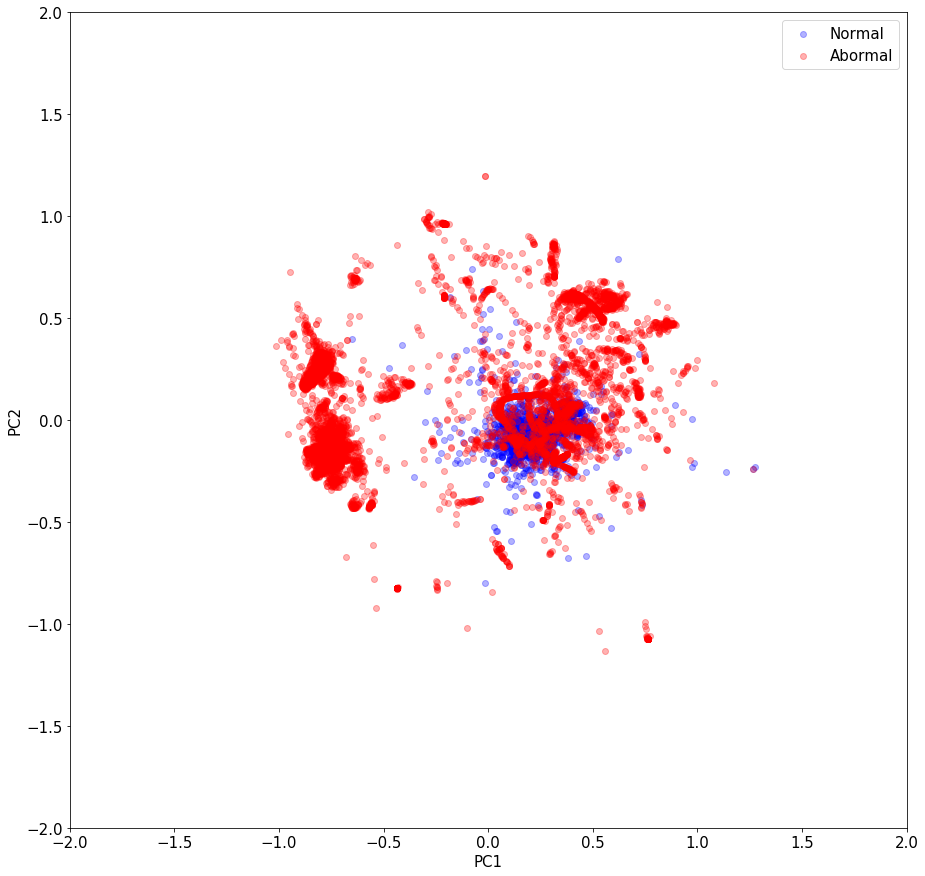

In [43]:
fig = plt.figure(figsize=(15, 15))

plt.scatter(
    x=list(map(lambda data: data[0], pca_normal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
plt.scatter(
    x=list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)

plt.xlim(-2, 2)
plt.ylim(-2, 2)

font_size = 15

plt.xlabel("PC1", fontsize=font_size)
plt.ylabel("PC2", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)

plt.savefig("./plot/sae_latent_2d.png")
plt.show()

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

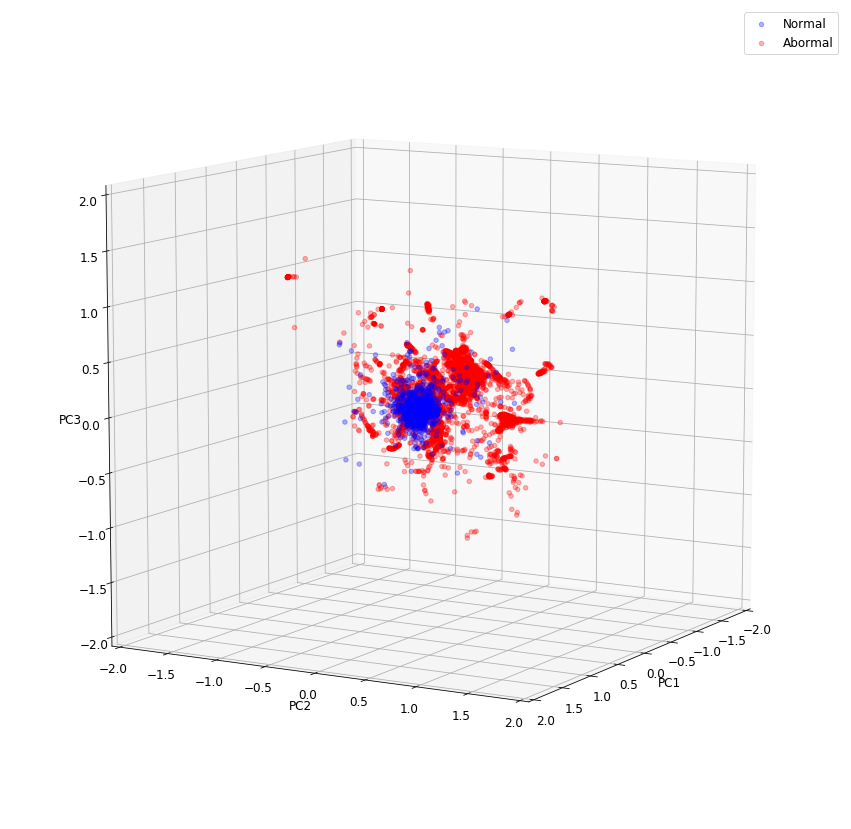

In [44]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

ax.scatter(
    list(map(lambda data: data[0], pca_normal_latent_data_list)),
    list(map(lambda data: data[1], pca_normal_latent_data_list)),
    list(map(lambda data: data[2], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
ax.scatter(
    list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[2], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

font_size = 12

ax.set_xlabel("PC1", fontsize=font_size)
ax.set_ylabel("PC2", fontsize=font_size)
ax.set_zlabel("PC3", fontsize=font_size)
ax.tick_params(axis="x", labelsize=font_size)
ax.tick_params(axis="y", labelsize=font_size)
ax.tick_params(axis="z", labelsize=font_size)
ax.legend(fontsize=font_size)

# ax.view_init(elev=10., azim=30)
ax.view_init(elev=10., azim=30)

plt.savefig("./plot/sae_latent_3d.png")
plt.show()